# Titanic Survivors

It is a basic classification prepared for the Titanic competition on Kaggle with the aim of predicting survival of passengers by given ticket information.

The original notebook: https://www.kaggle.com/myasiny/taytanik-basic-classification

In [4]:
import os
import warnings
import numpy as np
import pandas as pd

# Ignore warnings

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# Show input data files

for dirname, _, filenames in os.walk("data/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/.DS_Store
data/test.csv
data/train.csv
data/result_template.csv


# DATA

In [7]:
# Train set

df_train = pd.read_csv("data/train.csv")
df_train.shape

(891, 12)

In [8]:
# Test set

df_test = pd.read_csv("data/test.csv")
df_test.shape

(418, 11)

In [9]:
# Combine features of test and train sets

df_both = df_train.loc[:, df_train.columns != "Survived"].append(df_test, ignore_index=True)
df_both.shape

(1309, 11)

In [10]:
df_both.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df_both.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### Pre-processing

##### Methods

In [12]:
# Replace null values

def fill_na(df, val):
    return df.fillna(val, inplace=True)

In [13]:
# Drop rows containing null values

def drop_na(df):
    return df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)

In [14]:
import re

# Check if a value exists in given columns

def val_exist(df, cols, val):
    for col in cols:
        if isinstance(val, str) and df[col].str.contains(val, na=False, flags=re.IGNORECASE).any():
            return True
        elif (isinstance(val, int) or isinstance(val, float)) and any(df[col] == val):
            return True
    return False

##### Features

In [15]:
# Get title info from passenger name

df_train["Title"] = df_train["Name"].apply(lambda x: x.split(".")[0].split(",")[1].strip())

In [16]:
df_train[["Name", "Title"]].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [17]:
# Get family size

df_train["FamilySize"] = df_train["SibSp"] + df_train["Parch"] + 1

In [18]:
df_train[["SibSp", "Parch", "FamilySize"]].head()

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1


In [19]:
# Drop passenger name and id columns

df_train = df_train.drop(["Name", "PassengerId"], axis=1)

In [20]:
# Columns containing text values
str_cols = ["Sex", "Ticket", "Cabin", "Embarked", "Title"]

val_exist(df_train, str_cols, "Bilinmiyor")

False

In [21]:
# Replace null values with a unique value

for col in str_cols:
    fill_na(df_train[col], "Bilinmiyor")

In [22]:
# Columns containing numeric values
int_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare", "FamilySize"]

for col in int_cols:
    print(val_exist(df_train, [col], df_train[col].mean(skipna=True)))

False
False
False
False
False
False


In [23]:
# Replace null values with column mean

for col in int_cols:
    fill_na(df_train[col], df_train[col].mean(skipna=True))

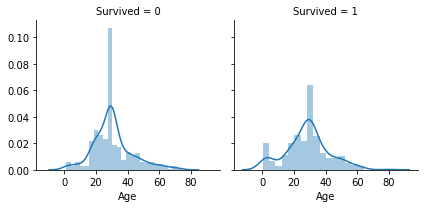

In [25]:
import seaborn as sns

# Visualization of survival by age

graph = sns.FacetGrid(df_train, col="Survived") 
graph = graph.map(sns.distplot, "Age")

### Processing

##### Methods

In [26]:
from sklearn.preprocessing import LabelBinarizer

# Convert text values to binary lists

def binarize(df):
    return LabelBinarizer().fit_transform(df).tolist()

In [27]:
# Convert binary lists to base-2 numbers

def base_two(df):
    return df.apply(lambda x: int("".join("{0}".format(i) for i in x), 2))

In [28]:
from sklearn.preprocessing import StandardScaler

# Scale values column-wise

def scaler(df):
    return StandardScaler().fit(df)

In [29]:
# Replace outliers with null values

def outlier(df):
    return df[np.abs(df - df.mean()) <= (3 * df.std())]

##### Features

In [30]:
for col in str_cols:
    df_train[col] = binarize(df_train[col])
    df_train[col] = base_two(df_train[col])

In [31]:
# Feature columns

df_feature = df_train.loc[:, df_train.columns != "Survived"]

# Scale values column-wise

std_scaler = scaler(df_feature)
df_feature.iloc[:,:] = std_scaler.transform(df_feature)

# Append labels

df_feature["Survived"] = df_train["Survived"]

df_feature.shape

(891, 12)

In [32]:
# Columns containing features

all_cols = ["Sex", "Ticket", "Cabin", "Embarked", "Title", "Pclass", "Age", "SibSp", "Parch", "Fare", "FamilySize"]

# Detect outliers

for col in all_cols:
    df_feature[col] = outlier(df_feature[col])
    
# Remove rows containing outliers

df_feature = drop_na(df_feature)

df_feature.shape

(811, 12)

In [33]:
from sklearn.model_selection import train_test_split

# Split train set into X and y

X, y = df_feature.loc[:, df_feature.columns != "Survived"], df_feature["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

(648, 11)

In [34]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
265,-0.369365,0.737695,0.484880,-0.474545,-0.473674,-0.0,-0.437007,-0.058124,-0.55506,-0.107328,-0.560975
486,-1.566107,-1.355574,0.407926,0.432793,-0.473674,-0.0,1.163700,-0.058124,-0.55506,-0.112986,0.059160
367,0.827377,-1.355574,0.000000,-0.474545,-0.473674,-0.0,-0.502864,-0.058124,1.93851,-0.112986,-0.560975
323,-0.369365,-1.355574,-0.592481,0.432793,0.767630,-0.0,-0.064516,-0.058124,-0.55506,-0.112986,0.679295
685,-0.369365,0.737695,-0.361618,0.432793,2.008933,-0.0,0.188763,-0.058124,1.93851,-0.107328,1.299429


# MODEL

### Classification

##### Methods

In [35]:
from sklearn.model_selection import GridSearchCV

# Find best parameters for given data and classifier

def best_params(classifier, parameters, X, y):
    clf = GridSearchCV(classifier, parameters)
    clf.fit(X, y)
    return clf.best_params_

In [36]:
from sklearn.metrics import accuracy_score

# Calculate accuracy of predictions by expected label set

def accuracy(name, y, predictions):
    return "Accuracy of {0}: {1}".format(name, accuracy_score(y, predictions))

##### Classifiers

In [37]:
from sklearn.svm import SVC

params_svc = {"C":[1, 10], "gamma":("scale", "auto"), "kernel":("linear", "rbf")}
best_params(SVC(), params_svc, X_train, y_train)

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [38]:
# Train SVC

clf_svc = SVC(C=1, gamma="auto", kernel="rbf")
clf_svc.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
print(accuracy("SVC", y_test, clf_svc.predict(X_test)))

Accuracy of SVC: 0.8159509202453987


In [40]:
from sklearn.neighbors import KNeighborsClassifier

params_kn = {"algorithm":("auto", "brute", "kd_tree"), "n_neighbors":[1, 3, 5]}
best_params(KNeighborsClassifier(), params_kn, X_train, y_train)

{'algorithm': 'brute', 'n_neighbors': 5}

In [41]:
# Train K-Neighbors

clf_kn = KNeighborsClassifier(algorithm="brute", n_neighbors=5)
clf_kn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [42]:
print(accuracy("K-Neighbors", y_test, clf_kn.predict(X_test)))

Accuracy of K-Neighbors: 0.8220858895705522


In [43]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {"class_weight":("balanced", "balanced_subsample"), "max_features":("auto", "log2"), "n_estimators":[10, 100]}
best_params(RandomForestClassifier(), params_rf, X_train, y_train)

{'class_weight': 'balanced', 'max_features': 'auto', 'n_estimators': 10}

In [44]:
# Train Random Forest

clf_rf = RandomForestClassifier(class_weight="balanced", max_features="auto", n_estimators=10)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
print(accuracy("Random Forest", y_test, clf_rf.predict(X_test)))

Accuracy of Random Forest: 0.7852760736196319


In [46]:
from sklearn.ensemble import GradientBoostingClassifier

params_gb = {"criterion":("friedman_mse", "mse", "mae"), "loss":("deviance", "exponential"), "max_features":("auto", "log2")}
best_params(GradientBoostingClassifier(), params_gb, X_train, y_train)

{'criterion': 'friedman_mse', 'loss': 'deviance', 'max_features': 'auto'}

In [47]:
# Train Gradient Boosting

clf_gb = GradientBoostingClassifier(criterion="friedman_mse", loss="deviance", max_features="auto")
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [48]:
print(accuracy("Gradient Boosting", y_test, clf_gb.predict(X_test)))

Accuracy of Gradient Boosting: 0.8220858895705522


In [49]:
from sklearn.naive_bayes import GaussianNB

# Train Gaussian Naive Bayes

clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [50]:
print(accuracy("Naive Bayes", y_test, clf_nb.predict(X_test)))

Accuracy of Naive Bayes: 0.7177914110429447


In [51]:
# Go on with the most accurate estimator

clf = clf_kn

### Estimator

##### Features

In [52]:
df_test["Title"] = df_test["Name"].apply(lambda x: x.split(".")[0].split(",")[1].strip())

In [53]:
df_test["FamilySize"] = df_test["SibSp"] + df_test["Parch"] + 1

In [54]:
for col in str_cols:
    fill_na(df_test[col], "Bilinmiyor")

In [55]:
for col in int_cols:
    fill_na(df_test[col], df_test[col].mean(skipna=True))

In [56]:
for col in str_cols:
    df_test[col] = binarize(df_test[col])
    df_test[col] = base_two(df_test[col])

In [57]:
data = df_test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked", "Title", "FamilySize"]]
data.iloc[:,:] = std_scaler.transform(data)

In [58]:
data.shape

(418, 11)

In [59]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,0.827377,0.737695,0.369449,-0.474545,-0.473674,-0.0,-0.490783,-0.058124,0.27613,-0.115815,-0.560975
1,0.827377,-1.355574,1.331378,0.432793,-0.473674,-0.0,-0.507479,-0.058124,-0.55506,-0.117229,0.059160
2,-0.369365,0.737695,2.485693,-0.474545,-0.473674,-0.0,-0.453367,-0.058124,0.27613,-0.115815,-0.560975
3,0.827377,0.737695,-0.207709,-0.474545,-0.473674,-0.0,-0.474005,-0.058124,-0.55506,-0.115815,-0.560975
4,0.827377,-1.355574,-0.592481,0.432793,0.767630,-0.0,-0.401017,-0.058124,-0.55506,-0.117229,0.679295


##### Predictions

In [60]:
# Survival predictions by main estimator

pred = clf.predict(data)

In [61]:
# Match survival info with passenger id

result = {}
for i in range(len(pred)):
    result[df_test.iloc[i]["PassengerId"]] = pred[i]

In [62]:
import csv

# Export the result as csv file

with open("out/result.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=["PassengerId", "Survived"])
    writer.writeheader()
    for key, val in result.items():
        writer.writerow({"PassengerId": key, "Survived": val})

# RESULT

In [64]:
df_result = pd.read_csv("out/result.csv")
df_result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


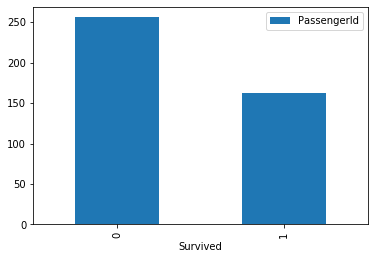

In [65]:
# Distribution of survival info

df_result.groupby(["Survived"]).count().plot(kind="bar")

Kaggle score: 0.77